In [1]:
# Note: the notebook parts should be run in sequence.

from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
%matplotlib inline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
from numpy import mean
from scipy.stats import pearsonr, ttest_ind, spearmanr

# Use these parameters to fine tune the evaluation
#######################################################
SAMPLE = 5000 # Training sample (Used: 5000, 20000)
GRANULARITY = 15000 # Only work with the last X blocks of data sets (Used: 15000, 220000)
REMOVE_OUTLIERS = False # False, or Number for whisker, 3 = only remove extreme outliers, not used in our evaluation
ONLY_TRANSPARENT = False # False, or True, filter for only TSP blocks

# Figure settings
SAVE_FIGURES = False
DPI = 300
FILE = '.pdf'

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

# Remove outliers if configured
if REMOVE_OUTLIERS:
    old_count_hdd = blocks_HDD['BLOCK'].count()
    old_count_ssd = blocks_SSD['BLOCK'].count()
    blocks_HDD = subset_by_iqr(blocks_HDD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS) 
    blocks_SSD = subset_by_iqr(blocks_SSD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS)
    print('Outliers: {} removed for HDD and {} removed for SSD'.format(old_count_hdd - blocks_HDD['BLOCK'].count(), old_count_ssd - blocks_SSD['BLOCK'].count()))

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
onlyContainingTransparent = blocks.loc[(blocks['numberJoinSplit'] == 0) & (blocks['numbervShieldedSpend'] == 0) & (blocks['numbervShieldedOutput'] == 0)]

if ONLY_TRANSPARENT:
    blocks = blocks[blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]

if GRANULARITY:
    blocks = blocks.tail(GRANULARITY)

print('Evaluation on Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])

Evaluation on Blocks 0000000000b3f611c39a11469981884bd0b34c9954c51c80a6c5d667729a88ec till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


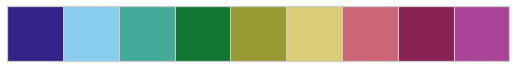

In [2]:
# Prepare plots
color = prepare_plots()

color_primary = color[0]
color_kb = color[2]
color_r2 = color_primary
color_kv = color[6]
color_gv = color[5]

name_benchmark = "Benchmark"
name_kv = "JOIST"
name_kb = "Block size"
name_gv = "Gervais $\it{et}$ $\it{al.}$"

In [3]:
# Now we use linear regression to predict the coefficients,
# we then calculate the errors based on a training and test split.
##############################
SHOW_COEF = False
MIN_TIME = False
#MIN_TIME = 870000000 # False or min verification time in ns (870000000ns = 10% of 8.7s, mean propagation time according to gervais et al.), not used in evaluation
#MIN_TIME = blocks['BLOCK_NS_SSD'].quantile(0.75)

estimates_reg = blocks.copy(deep=True)
test_size = SAMPLE / estimates_reg['BLOCK'].count()
X_train, X_test = train_test_split(estimates_reg, train_size=test_size, random_state=42)

if MIN_TIME:
    X_test = X_test[X_test["BLOCK_NS_SSD"] > MIN_TIME]

print('Test Blocks: ' + str(X_test['BLOCK'].count()))
print('Train Blocks: ' + str(X_train['BLOCK'].count()))

# Block size OLS
regr_kb_hdd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_HDD'])
X_test['KB_HDD'] = regr_kb_hdd.predict(X_test[["SIZE"]])
print(name_kb + ' HDD...')
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KB_HDD'])
print(name_kb + ' HDD adjst. R2: ', adj_r2_score(regr_kb_hdd, X_test['BLOCK_NS_HDD'], X_test['KB_HDD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kb_hdd.coef_)
    print('Intercept: \n', regr_kb_hdd.intercept_)

regr_kb_ssd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_SSD'])
X_test['KB_SSD'] = regr_kb_ssd.predict(X_test[["SIZE"]])
print(name_kb + ' SSD...')
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KB_SSD'])
print(name_kb + ' adjst. R2: ', adj_r2_score(regr_kb_ssd, X_test['BLOCK_NS_SSD'], X_test['KB_SSD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kb_ssd.coef_)
    print('Intercept: \n', regr_kb_ssd.intercept_)

# JOIST OLS
regr_kv_hdd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_HDD'])
X_test['KV_HDD'] = regr_kv_hdd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print("\n" + name_kv + ' HDD...')
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KV_HDD'])
print(name_kv + ' HDD adjst. R2: ', adj_r2_score(regr_kv_hdd, X_test['BLOCK_NS_HDD'], X_test['KV_HDD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kv_hdd.coef_)
    print('Intercept: \n', regr_kv_hdd.intercept_)  

regr_kv_ssd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_SSD'])
X_test['KV_SSD'] = regr_kv_ssd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print(name_kv + ' SSD...')
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KV_SSD'])
print(name_kv + ' adjst. R2: ', adj_r2_score(regr_kv_ssd, X_test['BLOCK_NS_SSD'], X_test['KV_SSD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kv_ssd.coef_)
    print('Intercept: \n', regr_kv_ssd.intercept_)

estimates_reg = X_test

r2_score_kv = r2_score(X_test['BLOCK_NS_SSD'], X_test['KV_SSD'])
r2_score_kb = r2_score(X_test['BLOCK_NS_SSD'], X_test['KB_SSD'])


Test Blocks: 10000
Train Blocks: 5000
Block size HDD...
MEAN aboslute error [ms]:  31.195802769236888
MAX error [ms]:  5396.243209117956
MEAN relative (%) error:  91.0796991027546
R2:  0.09099044724326855
Block size HDD adjst. R2:  0.09089952810416502
Block size SSD...
MEAN aboslute error [ms]:  10.594982491268016
MAX error [ms]:  1473.1114855546614
MEAN relative (%) error:  78.33573672636803
R2:  0.25197443361807337
Block size adjst. R2:  0.2518996160979311

JOIST HDD...
MEAN aboslute error [ms]:  22.051200672855643
MAX error [ms]:  5548.177754443923
MEAN relative (%) error:  64.38099179543188
R2:  0.16583717636109063
JOIST HDD adjst. R2:  0.1655033443156123
JOIST SSD...
MEAN aboslute error [ms]:  3.1090794591875786
MAX error [ms]:  840.3938446187217
MEAN relative (%) error:  22.987487726100838
R2:  0.9074870197437852
JOIST adjst. R2:  0.9074499960398308
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [4]:
# gervaivs' model
# we calculate the error on the test split
def model(meNS_Byte, estimates, postfix):
    estimates['GER_' + postfix] = meNS_Byte * estimates["SIZE"]
    calculate_error(estimates["BLOCK_NS_" + postfix], estimates['GER_' + postfix])

def r2_adj_man(par, real, predicted):
    return 1 - float(len(real)-1)/(len(real)-par-1)*(1 - r2_score(real, predicted))

gervais = X_test.copy(deep=True)
meNS_Byte = 379.6 # calculated from gervais

print('gervaivs KB SSD...')
model(meNS_Byte, gervais, 'SSD')
print('SSD adjst. R2: ', r2_adj_man(1, gervais["BLOCK_NS_SSD"], gervais['GER_SSD']))

print('gervaivs KB HDD...')
model(meNS_Byte, gervais, 'HDD')
print('HDD adjst. R2: ', r2_adj_man(1, gervais["BLOCK_NS_HDD"], gervais['GER_HDD']))

r2_score_ger = r2_score(gervais['BLOCK_NS_SSD'], gervais['GER_SSD'])

gervaivs KB SSD...
MEAN aboslute error [ms]:  11.658089214919997
MAX error [ms]:  1707.0374358
MEAN relative (%) error:  86.19599024586829
R2:  0.01367755877215504
SSD adjst. R2:  0.013578906797637291
gervaivs KB HDD...
MEAN aboslute error [ms]:  32.48408447622
MAX error [ms]:  5645.8861812
MEAN relative (%) error:  94.84098426985129
R2:  -0.028878280054932537
HDD adjst. R2:  -0.028981188464620056


In [5]:
# Sanity check with Linear regression with statsmodels
########################################################
X = sm.add_constant(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])

est = sm.OLS(X_test['BLOCK_NS_SSD'], X)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BLOCK_NS_SSD   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 2.490e+04
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:29:45   Log-Likelihood:            -1.7811e+05
No. Observations:               10000   AIC:                         3.562e+05
Df Residuals:                    9995   BIC:                         3.563e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.084e+06   1.44e+05     28.283      0.000     3.8e+06    4.37e+06
numberVin              6.753e+04   2574.587     26.229      0.000    6.25e+04    7.26e+04
numberJoinSplit        1.767e+07   6.64e+04    266.071      0.000    1.75e+07    1.78e+07
numbervShieldedSpend   5.738e+06   4.66e+04    123.156      0.000    5.65e+06    5.83e+06
numbervShieldedOutput  5.512e+06   6.82e+04     80.850      0.000    5.38e+06    5.65e+06
==============================================================================
Omnibus:                    30108.253   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2690901731.905
Skew:                          44.050   Prob(JB):                         0.00
Kurtosis:                    2542.764   Cond. No.                         60.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# We Compare estimated and real verification time with block size
##################################################
estimates_KB = estimates_reg.copy(deep=True)
estimates_KB = estimates_KB.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'})
estimates_KB['KB_GER'] = gervais["GER_SSD"]

# melt data
gridplotdata = pd.melt(estimates_KB, id_vars=['KB_HDD', 'KB_SSD', 'KB_GER', 'BLOCK', 'SIZE'], value_vars=['HDD', 'SSD'])

# Prepare plot
gridplotdata["SIZE"] = gridplotdata["SIZE"] / 1024 # Convert to Kibibyte
gridplotdata["value"] = gridplotdata["value"] / 1000000 # Convert to ms
gridplotdata["KB_HDD"] = gridplotdata["KB_HDD"] / 1000000 # Convert to ms
gridplotdata["KB_GER"] = gridplotdata["KB_GER"] / 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # Convert to ms

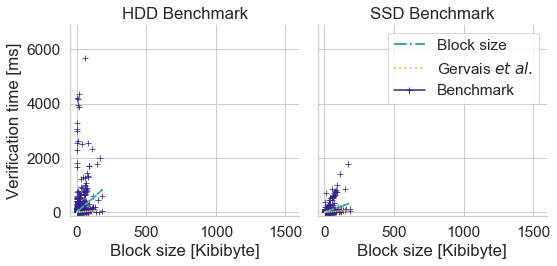

In [7]:
grid = sns.FacetGrid(gridplotdata, col="variable", height=4, aspect=1, legend_out=False)
grid = grid.map(sns.scatterplot, "SIZE", "value", color=color_primary, marker='+')
grid.set(ylim=(-150, 6900), xlim=(-50, 1600))

ax1, ax2 = grid.axes[0]
ax1.plot(gridplotdata["SIZE"], gridplotdata["KB_HDD"], ls='-.', color=color_kb)
ax2.plot(gridplotdata["SIZE"], gridplotdata["KB_SSD"], ls='-.', color=color_kb)

ax1.plot(gridplotdata["SIZE"], gridplotdata["KB_GER"], ls=':', color=color_gv)
ax2.plot(gridplotdata["SIZE"], gridplotdata["KB_GER"], ls=':', color=color_gv)

from matplotlib.lines import Line2D
b_patch = Line2D([0], [0], color=color_kb, ls='-.', lw=2, label=name_kb)
b2_patch = Line2D([0], [0], color=color_gv, ls=':', lw=2, label=name_gv)
g_patch = Line2D([0], [0], marker='+', color=color_primary, label=name_benchmark, markersize=7)
plt.legend(handles=[b_patch, b2_patch, g_patch])

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification time [ms]')
grid.set_titles('{col_name} Benchmark')

if SAVE_FIGURES:
    grid.fig.savefig("KB_SIZE" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [8]:
# We Compare errors between the models in relation to verification times
##################################################

model_error = estimates_reg.copy(deep=True)
model_error["GER"] = gervais["GER_SSD"]

def relative_error(real, predict):
    return (abs(real - predict) / real)

def abs_error(real, predict):
    return (abs(real - predict))

model_error['KV_HDD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_HDD'], row['KV_HDD'])), axis = 1) 
model_error['KV_SSD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_SSD'], row['KV_SSD'])), axis = 1) 

model_error['KB_HDD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_HDD'], row['KB_HDD'])), axis = 1) 
model_error['KB_SSD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_SSD'], row['KB_SSD'])), axis = 1) 

model_error['KV_HDD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_HDD'], row['KV_HDD'])), axis = 1) 
model_error['KV_SSD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['KV_SSD'])), axis = 1) 

model_error['KB_HDD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_HDD'], row['KB_HDD'])), axis = 1) 
model_error['KB_SSD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['KB_SSD'])), axis = 1) 

model_error['GER_SSD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['GER'])), axis = 1) 

model_error_ssd = pd.melt(model_error.rename(columns={'KV_SSD_mae': name_kv, 'KB_SSD_mae': name_kb}), id_vars=['BLOCK', 'SIZE', 'BLOCK_NS_SSD'], value_vars=[name_kv, name_kb], var_name='Model', value_name='MAE')

model_error_hdd = pd.melt(model_error.rename(columns={'KV_HDD_mae': name_kv, 'KB_HDD_mae': name_kb}), id_vars=['BLOCK', 'SIZE', 'BLOCK_NS_HDD'], value_vars=[name_kv, name_kb], var_name='Model', value_name='MAE')

model_error_ssd["BLOCK_NS_SSD"] = model_error_ssd["BLOCK_NS_SSD"] / 1000000 # Convert to mss
model_error_ssd["MAE"] = model_error_ssd["MAE"] / 1000000 # Convert to mss
model_error_ssd["SIZE"] = model_error_ssd["SIZE"] / 1024 # Convert to Kibibyte

model_error_hdd["BLOCK_NS_HDD"] = model_error_hdd["BLOCK_NS_HDD"] / 1000000 # Convert to mss
model_error_hdd["MAE"] = model_error_hdd["MAE"] / 1000000 # Convert to mss
model_error_hdd["SIZE"] = model_error_hdd["SIZE"] / 1024 # Convert to Kibibyte

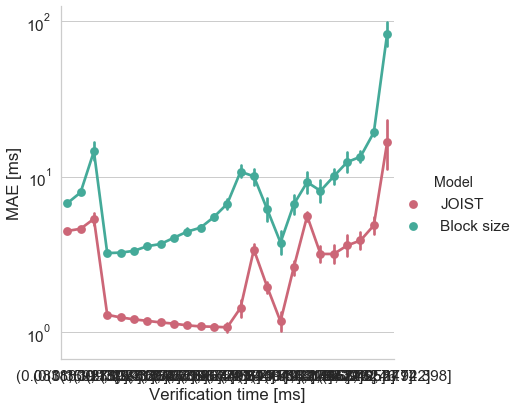

In [9]:
# We plot absolute errors between the models in relation to verification times
##################################################
Q = 25
d1_bins = model_error_ssd.copy(deep=True)
d1_bins['NS_BINS'] = pd.qcut(d1_bins['BLOCK_NS_SSD'], Q)

g = sns.catplot(x="NS_BINS", 
                y="MAE",
                kind="point",
                estimator=mean,
                hue="Model",
                height=6,
                data=d1_bins,
                palette=[color_kv, color_kb]);
g.set(ylabel="MAE [ms]", xlabel="Verification time [ms]", yscale='log')

if SAVE_FIGURES:   
    g.fig.savefig("MAE_SSD" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

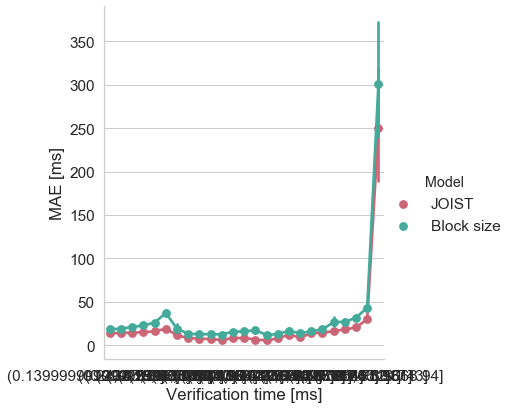

In [10]:
# We plot absolute errors between the models in relation to verification times

d1_bins = model_error_hdd.copy(deep=True)
d1_bins['NS_BINS'], edges = pd.qcut(d1_bins['BLOCK_NS_HDD'], Q, retbins=True)

g = sns.catplot(x="NS_BINS", 
                y="MAE",
                kind="point",
                estimator=mean,
                hue="Model",
                height=6,
                data=d1_bins,
                palette=[color_kv, color_kb]);
g.set(ylabel="MAE [ms]", xlabel="Verification time [ms]")

if SAVE_FIGURES:   
    g.fig.savefig("MAE_HDD" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

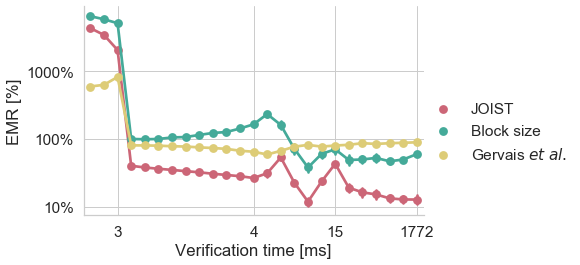

In [11]:
# We plot relative errors between the models in relation to verification times

d1_bins = pd.melt(model_error.rename(columns={'KV_SSD_re': name_kv, 'KB_SSD_re': name_kb, 'GER_SSD_re': name_gv}), id_vars=['BLOCK', 'SIZE', 'BLOCK_NS_SSD'], value_vars=[name_kv, name_kb, name_gv], var_name='Model', value_name='EMR')
d1_bins["BLOCK_NS_SSD"] = d1_bins["BLOCK_NS_SSD"] / 1000000 # Convert to mss
d1_bins['NS_BINS'], edges = pd.qcut(d1_bins['BLOCK_NS_SSD'], Q, retbins=True)

g = sns.catplot(x="NS_BINS", 
                y="EMR",
                kind="point",
                estimator=mean,
                legend=False,
                hue="Model",
                height=4,
                aspect=1.5,
                data=d1_bins,
                palette=[color_kv, color_kb, color_gv], orient='v');

g.set(ylabel="EMR [%]", xlabel="Verification time [ms]", yscale='log')
g.add_legend()

edges = edges.astype(int)
from matplotlib.ticker import PercentFormatter 
for ax in g.axes.flat:
    ax.set_xticklabels(edges)

ticks = ax.get_xticks()
labels = ax.get_xticklabels()
for ax in g.axes.flat:
    ax.set_xticks([ticks[2], ticks[12], ticks[18], ticks[24]])
    ax.xaxis.grid(True)
    ax.set_xticklabels([edges[3], edges[13], edges[19], edges[25]])
    ax.yaxis.set_major_formatter(PercentFormatter(1))

if SAVE_FIGURES:   
    g.fig.savefig("EMR" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [13]:
# Compare all model predictions in relation to block size
estimates_reg['GER_HDD'] = gervais["GER_SSD"]
estimates_reg['GER_SSD'] = gervais["GER_SSD"]

d1 = pd.melt(estimates_reg.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'}), id_vars=['BLOCK', 'SIZE', 'KV_SSD', 'KV_HDD', 'KB_SSD', 'KB_HDD', 'GER_HDD', 'GER_SSD'], value_vars=['HDD', 'SSD'], var_name='Type', value_name=name_benchmark)

d1['KV'] = d1['KV_HDD']
d1['KB'] = d1['KB_HDD']
d1['GER'] = d1['GER_HDD']

d1.loc[d1['Type'] == 'SSD', 'KV'] = d1['KV_SSD']
d1.loc[d1['Type'] == 'SSD', 'KB'] = d1['KB_SSD']

d1 = pd.melt(d1.rename(columns={'KV': name_kv, 'KB': name_kb, 'GER': name_gv}), id_vars=['BLOCK', 'SIZE', 'Type'], value_vars=[name_benchmark, name_kv, name_kb, name_gv], var_name='Model', value_name='NS')

d1["NS"] = d1["NS"] / 1000000 # Convert to mss
d1["SIZE"] = d1["SIZE"] / 1024 # Convert to Kibibyte

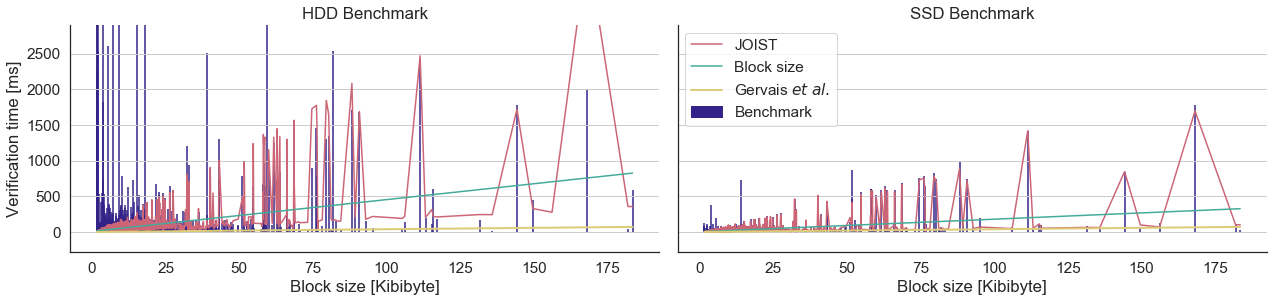

In [14]:
# We plot all model predictions in relation to block size
# Caution: This might take a while!
sns.set(style="white", font_scale=1.4)

grid = sns.FacetGrid(d1[(d1['Model']!='Benchmark')], col="Type", height=4.5, aspect=2, hue="Model", hue_kws={'color':[color_kv, color_kb, color_gv], 'ls': ["--", "-", "-"], 'lw': [1.5, 1.5, 2]}, legend_out=False)
ax1, ax2 = grid.axes[0]
ax1.set_rasterization_zorder(0.1);
ax2.set_rasterization_zorder(0.1);

grid = grid.map(sns.lineplot, "SIZE", "NS")
for _, row in d1[(d1['Model']=='Benchmark') & (d1['Type']=='HDD')].iterrows():
    ax1.vlines(x=row["SIZE"], ymax=row["NS"], ymin=0, color=color_primary, zorder=0)

for _, row in d1[(d1['Model']=='Benchmark') & (d1['Type']=='SSD')].iterrows():
    ax2.vlines(x=row["SIZE"], ymax=row["NS"], ymin=0, color=color_primary, zorder=0)

grid.set(ylim=(None, 2900))
ax1.grid(axis='y')
ax2.grid(axis='y')
ax2.legend(title='')

import matplotlib.patches as mpatches
# where some data has already been plotted to ax
handles, labels = ax2.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color=color_primary, label='Benchmark')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax2.legend(handles=handles, loc='upper left')

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification time [ms]')
grid.set_titles('{col_name} Benchmark')

if SAVE_FIGURES:
    sns.set(font_scale=1.5)
    grid.fig.savefig("KV_KB_Size" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)


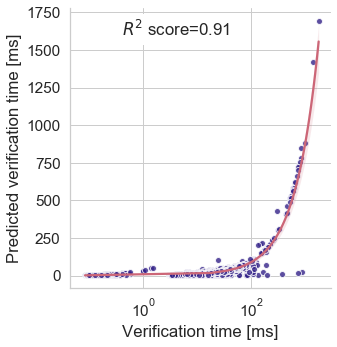

In [15]:
# Compare model predictions with real values
sns.set(style="whitegrid", font_scale=1.4)

HEIGHT=5
RATIO=1
ZOOM = False #750
gridplotdata = estimates_reg.copy(deep=True)

gridplotdata["BLOCK_NS_SSD"] = gridplotdata["BLOCK_NS_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KV_SSD"] = gridplotdata["KV_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["GER_SSD"] = gridplotdata["GER_SSD"] / 1000000 # 1000000 # Convert to ms

grid = sns.lmplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KV_SSD', height=HEIGHT, aspect=RATIO, scatter_kws={'edgecolor': 'white', 'color': color_r2, 'marker':['+'], 'rasterized':True}, line_kws={'color': color_kv})

# Plot preditcions of JOIST OLS
if ZOOM:
    grid.set(ylim=(0, ZOOM))
    grid.set(xlim=(0, ZOOM))

grid.axes.ravel()[0].annotate("$R^2$ score=" + str(round(r2_score_kv, 2)), (0.2, 0.9), bbox=dict(boxstyle="square", fc="w"), xycoords='axes fraction')

grid.set(xscale='log', xlabel='Verification time [ms]', ylabel='Predicted verification time [ms]')

if SAVE_FIGURES:
    grid.fig.savefig("KV_R2" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

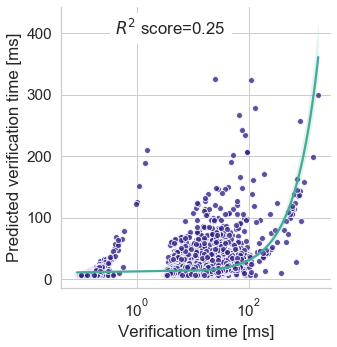

In [16]:
# Plot preditcions of block size OLS

grid = sns.lmplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KB_SSD', height=HEIGHT, aspect=RATIO, scatter_kws={'edgecolor': 'white', 'color': color_r2, 'marker':['+'], 'rasterized':True}, line_kws={'color': color_kb})

grid.axes.ravel()[0].annotate("$R^2$ score=" + str(round(r2_score_kb, 2)), (0.2, 0.9), bbox=dict(boxstyle="square", fc="w"), xycoords='axes fraction')

grid.set(xscale='log', xlabel='Verification time [ms]', ylabel='Predicted verification time [ms]')

if SAVE_FIGURES:
    grid.fig.savefig("KB_R2" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

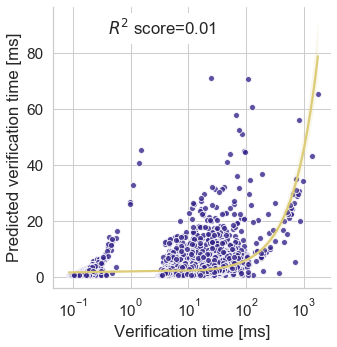

In [17]:
# Plot preditcions of Gervais

grid = sns.lmplot(data=gridplotdata, x='BLOCK_NS_SSD', y='GER_SSD', height=HEIGHT, aspect=RATIO, scatter_kws={'edgecolor': 'white', 'color': color_r2, 'marker':['+'], 'rasterized':True}, line_kws={'color': color_gv})

grid.axes.ravel()[0].annotate("$R^2$ score=" + str(round(r2_score_ger, 2)), (0.2, 0.9), bbox=dict(boxstyle="square", fc="w"), xycoords='axes fraction')

grid.set(xscale='log', xlabel='Verification time [ms]', ylabel='Predicted verification time [ms]')

if SAVE_FIGURES:
    grid.fig.savefig("GER_R2" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [18]:
# Max Error analysis
max_joist = d1[d1["Model"] == name_kv]['NS'].max()
max_block = d1[d1["Model"] == name_kb]['NS'].max()
max_gervais = d1[d1["Model"] == name_gv]['NS'].max()

block_count = d1[d1["Model"] == "Benchmark"].count()

print("Blocks not covered by JOIST: ", d1[d1['NS'] > max_joist].count())
print(d1[d1['NS'] > max_joist].count() * 100 / block_count)

print("Blocks not covered by BLOCK: ", d1[d1['NS'] > max_block].count())
print(d1[d1['NS'] > max_block].count() * 100 / block_count)

print("Blocks not covered by GERVAIS: ", d1[d1['NS'] > max_gervais].count())
print(d1[d1['NS'] > max_gervais].count() * 100 / block_count)


Blocks not covered by JOIST:  BLOCK    4
SIZE     4
Type     4
Model    4
NS       4
dtype: int64
BLOCK    0.02
SIZE     0.02
Type     0.02
Model    0.02
NS       0.02
dtype: float64
Blocks not covered by BLOCK:  BLOCK    68
SIZE     68
Type     68
Model    68
NS       68
dtype: int64
BLOCK    0.34
SIZE     0.34
Type     0.34
Model    0.34
NS       0.34
dtype: float64
Blocks not covered by GERVAIS:  BLOCK    2849
SIZE     2849
Type     2849
Model    2849
NS       2849
dtype: int64
BLOCK    14.245
SIZE     14.245
Type     14.245
Model    14.245
NS       14.245
dtype: float64


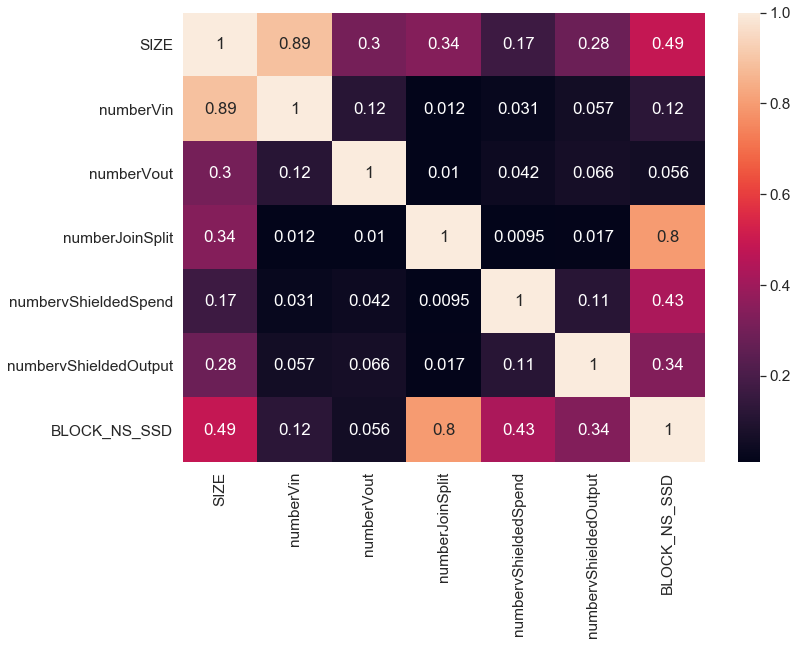

In [19]:
# Analyse the Correlation of features with block verfication time
#############################
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

data_cor = blocks[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]]

corrMatrix = data_cor[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]].corr()
pvalues = data_cor[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]].corr(method=pearsonr_pval)
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [20]:
# Print correlation coefficients
abs(corrMatrix['BLOCK_NS_SSD'].sort_values())

numberVout               0.056160
numberVin                0.124236
numbervShieldedOutput    0.335796
numbervShieldedSpend     0.430726
SIZE                     0.487774
numberJoinSplit          0.795232
BLOCK_NS_SSD             1.000000
Name: BLOCK_NS_SSD, dtype: float64

In [22]:
# test for p
pvalues['BLOCK_NS_SSD'] < 0.01

SIZE                      True
numberVin                 True
numberVout                True
numberJoinSplit           True
numbervShieldedSpend      True
numbervShieldedOutput     True
BLOCK_NS_SSD             False
Name: BLOCK_NS_SSD, dtype: bool